# Manns Lab Data integration 

This notebook explores the differences in the PILOT and MAIN datasets, and how to integrate these datasets for further analysis.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr
import warnings

import manns_lab_support as sup

warnings.filterwarnings("ignore")

np.random.seed(0)

In [2]:
MAIN_DIR = "../data/manns_lab/MAIN/"
PILOT_DIR = "../data/manns_lab/PILOT/"

In [3]:
main_adata = sup.load_main_data(MAIN_DIR)
main_adata = sup.preprocess(main_adata)

pilot_adata = sup.load_pilot_data(PILOT_DIR)
pilot_adata = sup.preprocess(pilot_adata)

input: (5045, 2703)
sc.pp.filter_genes: (5045, 2703)
sc.pp.filter_cells: (5045, 2703)
filter: (4566, 2018)
input: (461, 3306)
sc.pp.filter_genes: (461, 3305)
sc.pp.filter_cells: (461, 3305)
filter: (454, 2963)


In [4]:
combined_adata = sup.combine_PILOT_and_MAIN(pilot_adata, main_adata)

Nr. patients | main: 4566, pilot: 454, in both: 447
Nr. proteins | main: 2018, pilot: 2963, in both: 1783


In [5]:
sup.print_combined_summary(combined_adata)

Percentage non-missing intensity entries for patients in both PILOT and MAIN (patients: 447):
  2018 unique proteins (all those in MAIN):      76.32%
  1783 unique proteins (in both MAIN and PILOT): 86.38%

Percentage non-missing intensity entries using MAIN layout (patients: 4566, proteins: 2018)
  MAIN:     69.66%
  PILOT:    7.47%
  combined: 71.28%


In [6]:
combined_adata.X = combined_adata.layers["MAIN"].copy()
sup.correct_batch(combined_adata)
combined_adata.layers["MAIN_corrected"] = combined_adata.X.copy()

combined_adata.X = combined_adata.layers["PILOT"].copy()
sup.correct_batch(combined_adata)
combined_adata.layers["PILOT_corrected"] = combined_adata.X.copy()

In [7]:
combined_adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 4566 × 2018
    obs: 'Run', 'Experiment', 'Sex', 'Age', 'MSgroup', 'Diagnosis_group', 'Diagnosis_group_subtype', 'Diagnosis_group_autoimmune_split', 'RMS_PMS', 'Plate', 'Preparation day', 'Sample_position', 'Sample_row', 'Sample_column', 'Leukocyte count', 'Leukocyte_count_log2', 'Erythrocytes', 'Total protein', 'Total_protein_log2', 'Albumin CSF', 'Albumin_CSF_log2', 'Qalb', 'QAlb_log2', 'Diff_age_adj_QAlb', 'Diff_age_adj_QAlb_log2', 'IgG CSF', 'IgG_CSF_log2', 'QIgG', 'QIgG_log2', 'Sample_injection_number', 'Sample_injection_order', 'Sample_plate_order', 'Sample_plate_order_inCrossSectional', 'Depth_PG', 'Depth_Gene', 'EvoSep', 'LC_column', 'Emitter', 'Capillary', 'MS_calibration', 'Evosept', 'Column', 'Maintenance', 'log Qalb', 'File.Name', 'Precursors.Identified', 'Proteins.Identified', 'Total.Quantity', 'MS1.Signal', 'MS2.Signal', 'FWHM.Scans', 'FWHM.RT', 'Median.Mass.Acc.MS1', 'Median.Mass.Acc.MS1.Corrected', '

Text(619.9949494949494, 0.5, 'PILOT intensity')

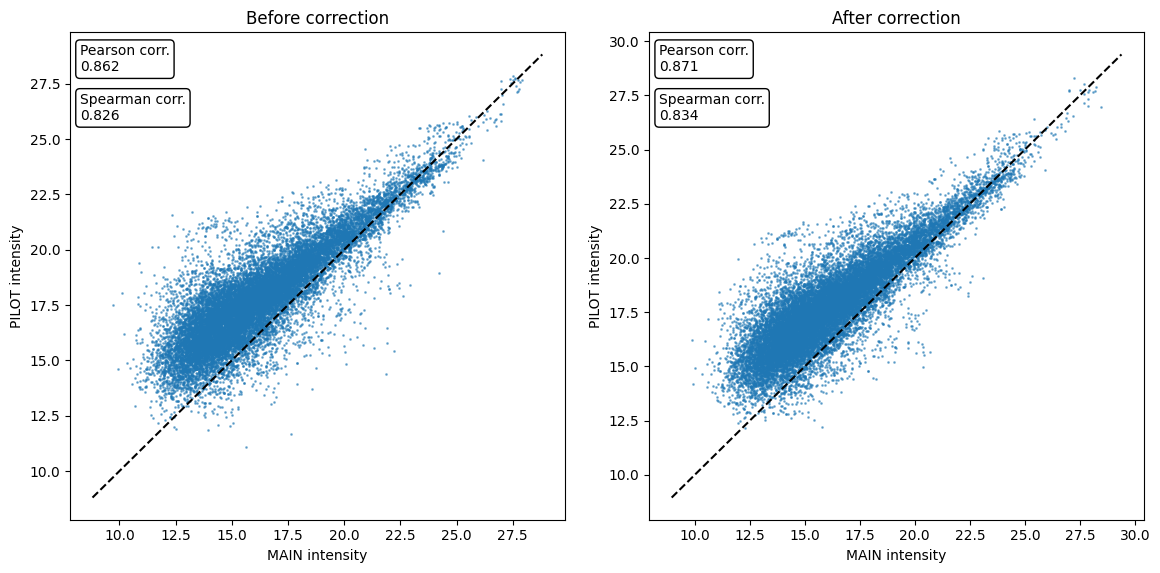

In [8]:
N = 20_000

overlap_filter = np.logical_and(~np.isnan(combined_adata.layers["PILOT"]), ~np.isnan(combined_adata.layers["MAIN"]))

ns = np.random.choice(np.sum(overlap_filter), size=N)

fig, axes = plt.subplots(figsize=(12, 6), ncols=2)
fig.tight_layout(pad=3)

# before batch correction
ax = axes[0]

intensity_MAIN = combined_adata.layers["MAIN"][overlap_filter]
intensity_PILOT = combined_adata.layers["PILOT"][overlap_filter]

intensity_MAIN = intensity_MAIN[ns]
intensity_PILOT = intensity_PILOT[ns]

pearson = pearsonr(intensity_MAIN, intensity_PILOT)
ax.text(0.02, 0.92, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

spearman = spearmanr(intensity_MAIN, intensity_PILOT)
ax.text(0.02, 0.82, f"Spearman corr.\n{spearman[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

ax.scatter(intensity_MAIN, intensity_PILOT, s=1, alpha=0.5)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color="black", linestyle="--")
ax.set_title(f"Before correction")
ax.set_xlabel("MAIN intensity")
ax.set_ylabel("PILOT intensity")

# after batch correction
ax = axes[1]

intensity_MAIN = combined_adata.layers["MAIN_corrected"][overlap_filter]
intensity_PILOT = combined_adata.layers["PILOT_corrected"][overlap_filter]

intensity_MAIN = intensity_MAIN[ns]
intensity_PILOT = intensity_PILOT[ns]

pearson = pearsonr(intensity_MAIN, intensity_PILOT)
ax.text(0.02, 0.92, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

spearman = spearmanr(intensity_MAIN, intensity_PILOT)
ax.text(0.02, 0.82, f"Spearman corr.\n{spearman[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

ax.scatter(intensity_MAIN, intensity_PILOT, s=1, alpha=0.5)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color="black", linestyle="--")
ax.set_title(f"After correction")
ax.set_xlabel("MAIN intensity")
ax.set_ylabel("PILOT intensity")

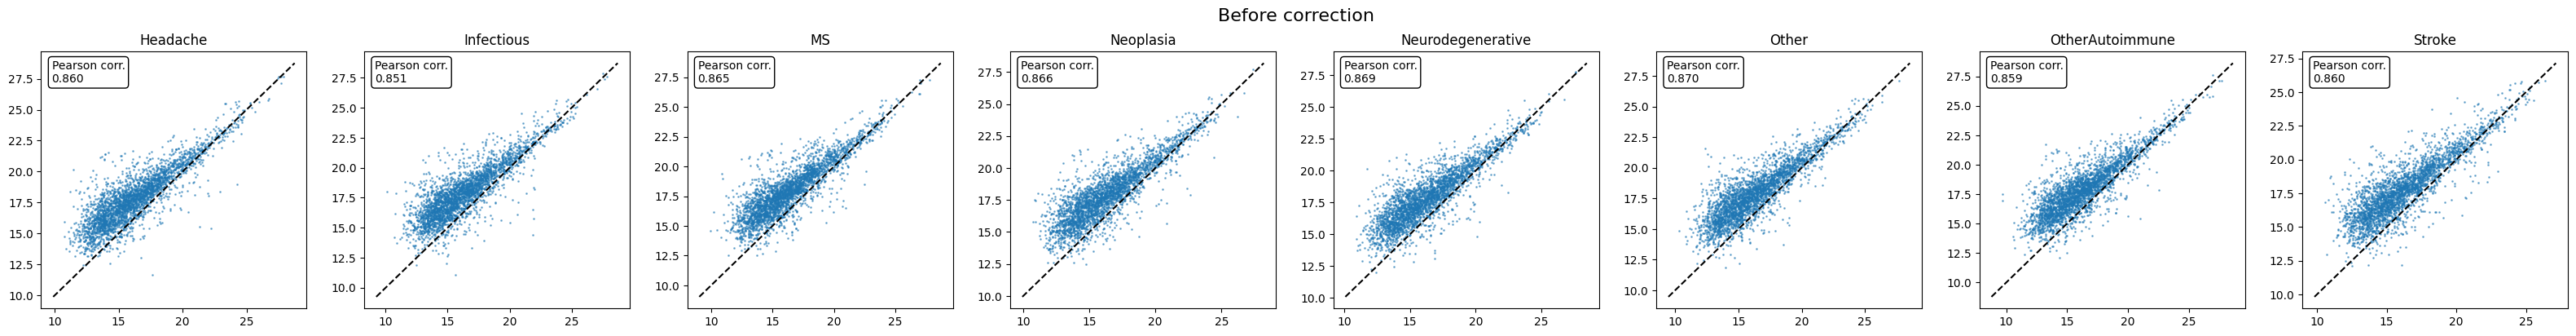

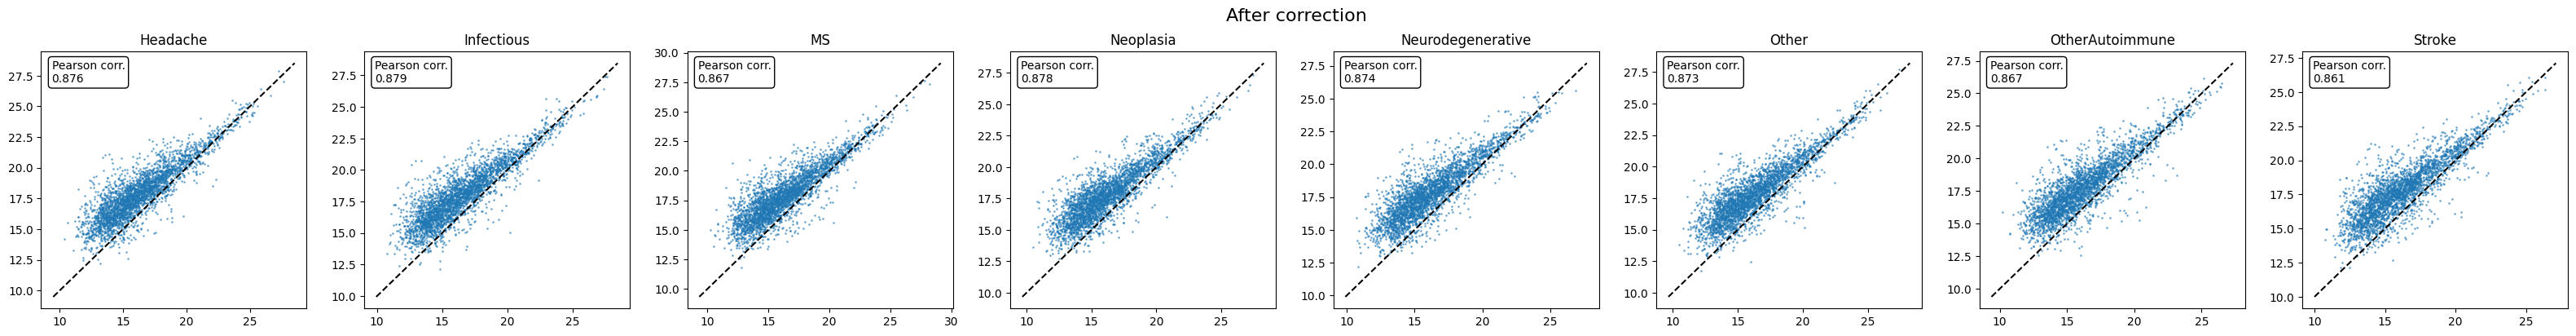

In [9]:
N = 3_000

obs_color_annotation = combined_adata.obs["Diagnosis_group"]

# before batch correction
unique_obs_annotations = np.unique(obs_color_annotation)

fig, axes = plt.subplots(figsize=(4 * len(unique_obs_annotations), 4), ncols=len(unique_obs_annotations))
fig.tight_layout(pad=2)
fig.suptitle("Before correction", fontsize=16, y=1.05)

np.random.seed(0)

for i, annotation in enumerate(unique_obs_annotations):
    ax = axes[i]
    annotation_filter = np.tile(np.array(obs_color_annotation == annotation).reshape(-1, 1), combined_adata.n_vars)
    overlap_filter = np.logical_and(~np.isnan(combined_adata.layers["PILOT"]), ~np.isnan(combined_adata.layers["MAIN"]), annotation_filter)

    intensity_MAIN = combined_adata.layers["MAIN"][overlap_filter]
    intensity_PILOT = combined_adata.layers["PILOT"][overlap_filter]
    
    ns = np.random.choice(np.sum(overlap_filter), size=N)
    intensity_MAIN = intensity_MAIN[ns]
    intensity_PILOT = intensity_PILOT[ns]

    ax.scatter(intensity_MAIN, intensity_PILOT, s=1, alpha=0.5)
    ax.set_title(f"{annotation}")

    pearson = pearsonr(intensity_MAIN, intensity_PILOT)
    ax.text(0.04, 0.88, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="black", linestyle="--")

# after batch correction
fig, axes = plt.subplots(figsize=(4 * len(unique_obs_annotations), 4), ncols=len(unique_obs_annotations))
fig.tight_layout(pad=2)
fig.suptitle("After correction", fontsize=16, y=1.05)

for i, annotation in enumerate(unique_obs_annotations):
    ax = axes[i]
    annotation_filter = np.tile(np.array(obs_color_annotation == annotation).reshape(-1, 1), combined_adata.n_vars)
    overlap_filter = np.logical_and(~np.isnan(combined_adata.layers["PILOT"]), ~np.isnan(combined_adata.layers["MAIN"]), annotation_filter)

    intensity_MAIN = combined_adata.layers["MAIN_corrected"][overlap_filter]
    intensity_PILOT = combined_adata.layers["PILOT_corrected"][overlap_filter]
    
    ns = np.random.choice(np.sum(overlap_filter), size=N)
    intensity_MAIN = intensity_MAIN[ns]
    intensity_PILOT = intensity_PILOT[ns]

    ax.scatter(intensity_MAIN, intensity_PILOT, s=1, alpha=0.5)
    ax.set_title(f"{annotation}")

    pearson = pearsonr(intensity_MAIN, intensity_PILOT)
    ax.text(0.04, 0.88, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color="black", linestyle="--")

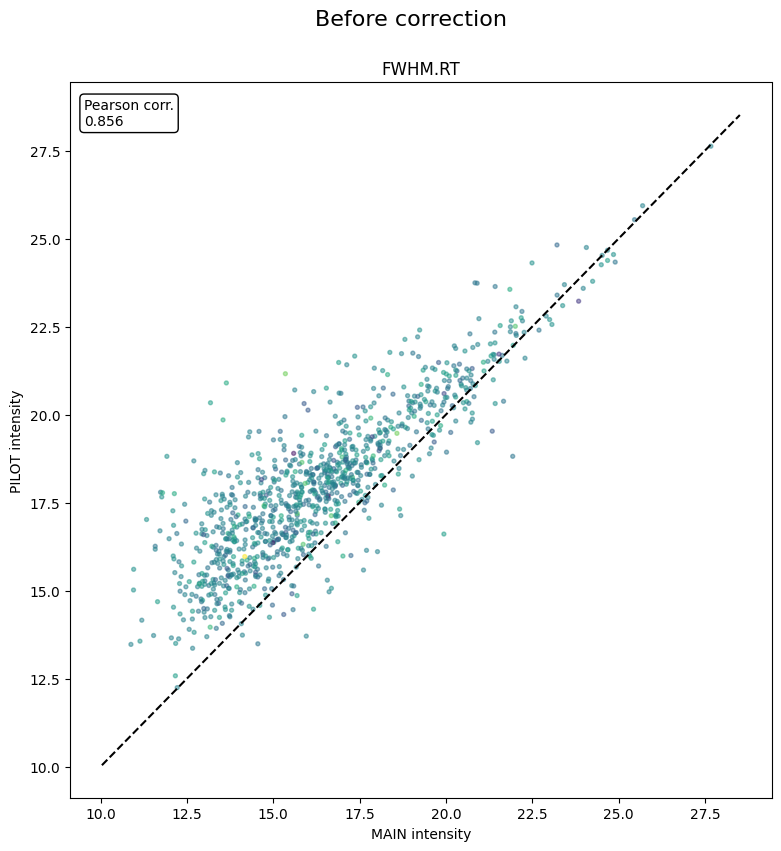

In [10]:
N = 1_000

annotation = "FWHM.RT"

obs_annotation = combined_adata.obs[annotation]
annotation_filter = np.tile(obs_annotation.values.reshape(-1, 1), combined_adata.n_vars)

fig, ax = plt.subplots(figsize=(8, 8))
fig.tight_layout(pad=2)
fig.suptitle("Before correction", fontsize=16, y=1.05)

overlap_filter = np.logical_and(~np.isnan(combined_adata.layers["PILOT"]), ~np.isnan(combined_adata.layers["MAIN"]))

intensity_MAIN = combined_adata.layers["MAIN"][overlap_filter]
intensity_PILOT = combined_adata.layers["PILOT"][overlap_filter]

ns = np.random.choice(np.sum(overlap_filter), size=N)
intensity_MAIN = intensity_MAIN[ns]
intensity_PILOT = intensity_PILOT[ns]

annotation_filter = annotation_filter[overlap_filter][ns]

ax.scatter(intensity_MAIN, intensity_PILOT, s=8, alpha=.5, c=annotation_filter)
ax.set_title(f"{annotation}")
ax.set_xlabel("MAIN intensity")
ax.set_ylabel("PILOT intensity")

pearson = pearsonr(intensity_MAIN, intensity_PILOT)
ax.text(0.02, 0.94, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color="black", linestyle="--")

In [12]:
main_ids = set(main_adata.obs_names)
pilot_ids = set(pilot_adata.obs_names)
ids = list(main_ids.intersection(pilot_ids))

empty = pd.DataFrame(index=main_adata.obs.index)
v = empty.combine_first(pilot_adata[ids].obs)

In [13]:
v = v.loc[main_adata.obs.index]
assert np.all(v.index == main_adata.obs.index)

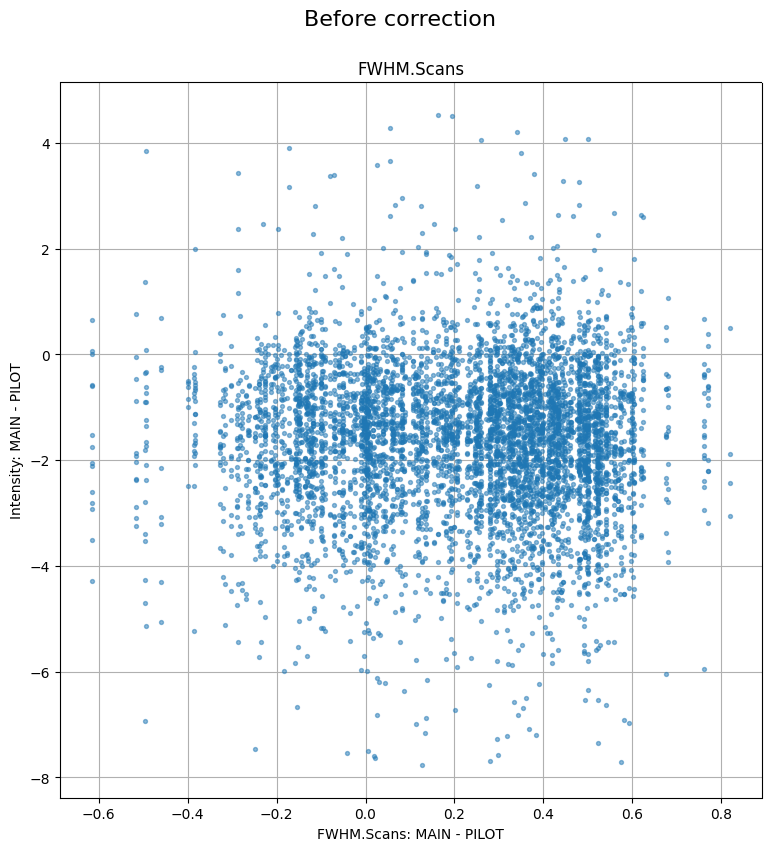

In [14]:
N = 6_000

annotation = "FWHM.Scans"

annotation_filter = np.tile(combined_adata.obs[annotation].values.reshape(-1, 1), combined_adata.n_vars)
annotation_filter2 = np.tile(v[annotation].values.reshape(-1, 1), combined_adata.n_vars)

fig, ax = plt.subplots(figsize=(8, 8))
fig.tight_layout(pad=2)
fig.suptitle("Before correction", fontsize=16, y=1.05)

overlap_filter = np.logical_and(~np.isnan(combined_adata.layers["PILOT"]), ~np.isnan(combined_adata.layers["MAIN"]))

ns = np.random.choice(np.sum(overlap_filter), size=N)

intensity_MAIN = combined_adata.layers["MAIN"][overlap_filter][ns]
intensity_PILOT = combined_adata.layers["PILOT"][overlap_filter][ns]

diff = intensity_MAIN - intensity_PILOT

annotation_filter = annotation_filter[overlap_filter][ns]
annotation_filter2 = annotation_filter2[overlap_filter][ns]
diff_annotation_filter = annotation_filter - annotation_filter2

ax.scatter(diff_annotation_filter, diff, s=8, alpha=.5)
ax.set_title(f"{annotation}")
ax.set_xlabel(f"{annotation}: MAIN - PILOT")
ax.set_ylabel("Intensity: MAIN - PILOT")
ax.grid(True)
ax.set_axisbelow(True)

In [17]:
combined_adata.obs[overlap_filter.any(axis=1)]

,Run,Experiment,Sex,Age,MSgroup,Diagnosis_group,Diagnosis_group_subtype,Diagnosis_group_autoimmune_split,RMS_PMS,Plate,...,Median.Mass.Acc.MS1.Corrected,Median.Mass.Acc.MS2,Median.Mass.Acc.MS2.Corrected,MS2.Mass.Instability,Normalisation.Instability,Median.RT.Prediction.Acc,Average.Peptide.Length,Average.Peptide.Charge,Average.Missed.Tryptic.Cleavages,n_genes
ID,,,,,,,,,,,,,,,,,,,,,
01_A_08,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,F,39.0,MS,MS,RMS,MS,RMS,plate1,...,1.82269,3.25583,2.36635,0,0.172719,0.031734,14.110,2.372,0.188,1662
01_A_12,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,F,35.0,MS,MS,RMS,MS,RMS,plate1,...,1.60810,3.00446,2.57069,0,0.126522,0.027596,13.950,2.343,0.158,1481
01_C_09,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,M,76.0,nonMS,Headache,NaN,Headache,NaN,plate1,...,1.87942,3.04653,2.50029,0,0.197070,0.027966,13.996,2.359,0.184,1720
01_F_06,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,M,56.0,nonMS,OtherAutoimmune,Inflammatory neuropathies,Autoimmune_notMSrelated,Inflammatory neuropathies,plate1,...,1.80893,3.15433,2.31070,0,0.465978,0.035829,15.106,2.457,0.288,1069
01_F_11,20211110_TIMS05_JaBa_SA_E1C1T1P1M01_35PLATE01_...,cross-sectional,F,71.0,nonMS,Neurodegenerative,NaN,Neurodegenerative,NaN,plate1,...,1.93752,3.70829,2.63017,0,0.229180,0.029650,13.968,2.356,0.173,1708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42_D_01,20220421_TIMS05_JaBa_SA_E3C4T5P4M12_35PLATE42R...,cross-sectional,F,20.0,MS,MS,RMS,MS,RMS,plate42,...,1.74090,7.27740,2.81634,0,0.268138,0.036683,14.050,2.353,0.194,1457
42_D_09,20220421_TIMS05_JaBa_SA_E3C4T5P4M12_35PLATE42R...,cross-sectional,F,40.0,MS,MS,RMS,MS,RMS,plate42,...,1.85189,7.58234,2.92168,0,0.218532,0.036843,13.551,2.309,0.183,1454
42_E_11,20220421_TIMS05_JaBa_SA_E3C4T5P4M12_35PLATE42R...,cross-sectional,F,36.0,MS,MS,RMS,MS,RMS,plate42,...,1.75166,3.42116,2.75767,0,0.131922,0.042094,14.055,2.354,0.194,1454


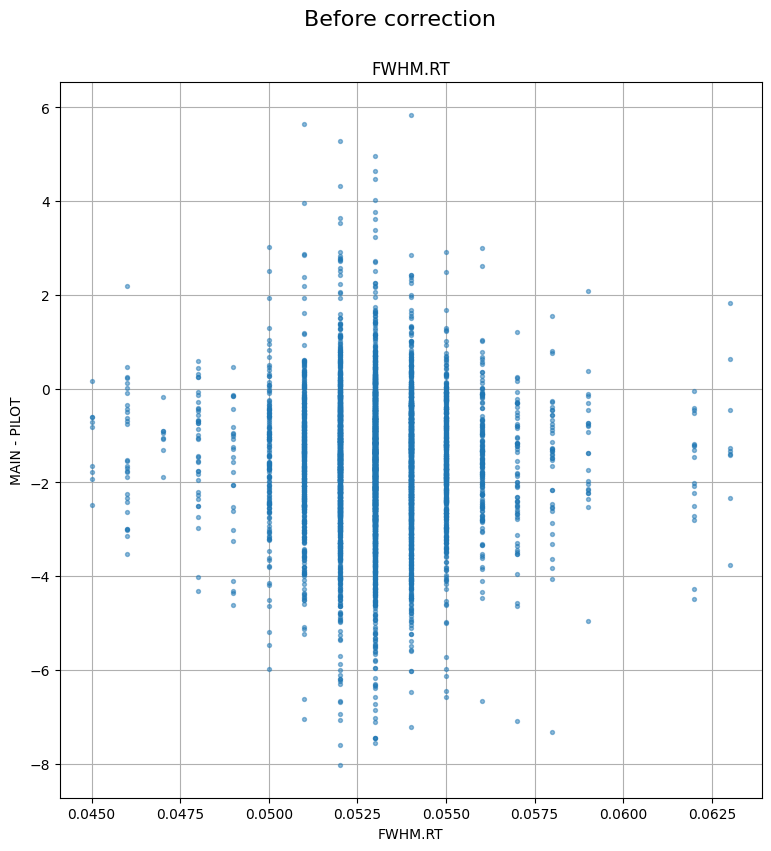

In [18]:
N = 6_000

annotation = "FWHM.RT"

obs_annotation = combined_adata.obs[annotation]
annotation_filter = np.tile(obs_annotation.values.reshape(-1, 1), combined_adata.n_vars)

fig, ax = plt.subplots(figsize=(8, 8))
fig.tight_layout(pad=2)
fig.suptitle("Before correction", fontsize=16, y=1.05)

ns = np.random.choice(np.sum(overlap_filter), size=N)

overlap_filter = np.logical_and(~np.isnan(combined_adata.layers["PILOT"]), ~np.isnan(combined_adata.layers["MAIN"]))

intensity_MAIN = combined_adata.layers["MAIN"][overlap_filter][ns]
intensity_PILOT = combined_adata.layers["PILOT"][overlap_filter][ns]

diff = intensity_MAIN - intensity_PILOT

annotation_filter = annotation_filter[overlap_filter][ns]

ax.scatter(annotation_filter, diff, s=8, alpha=.5)
ax.set_title(f"{annotation}")
ax.set_xlabel(f"{annotation}")
ax.set_ylabel("MAIN - PILOT")
ax.grid(True)
ax.set_axisbelow(True)

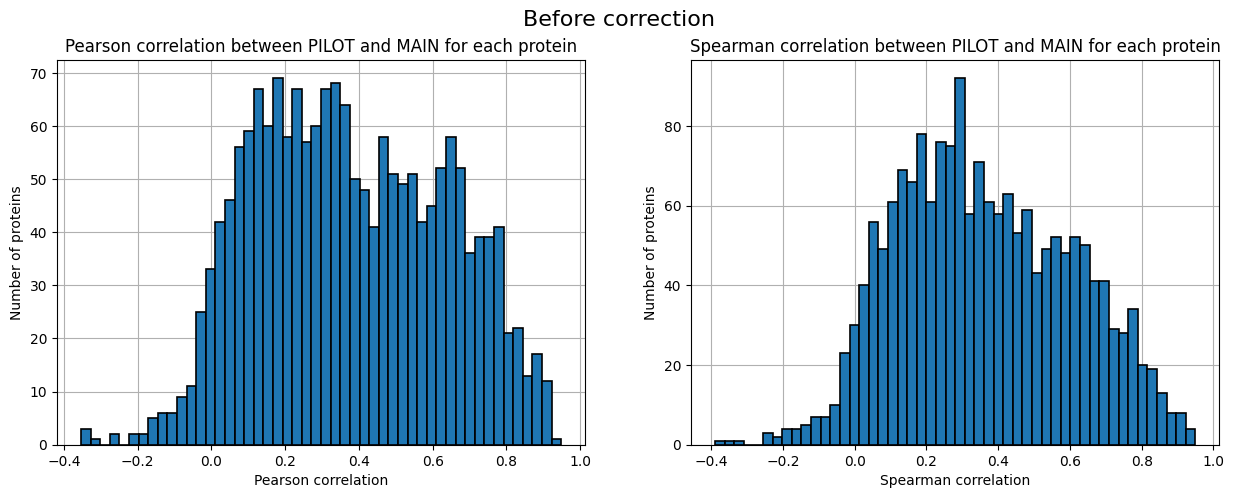

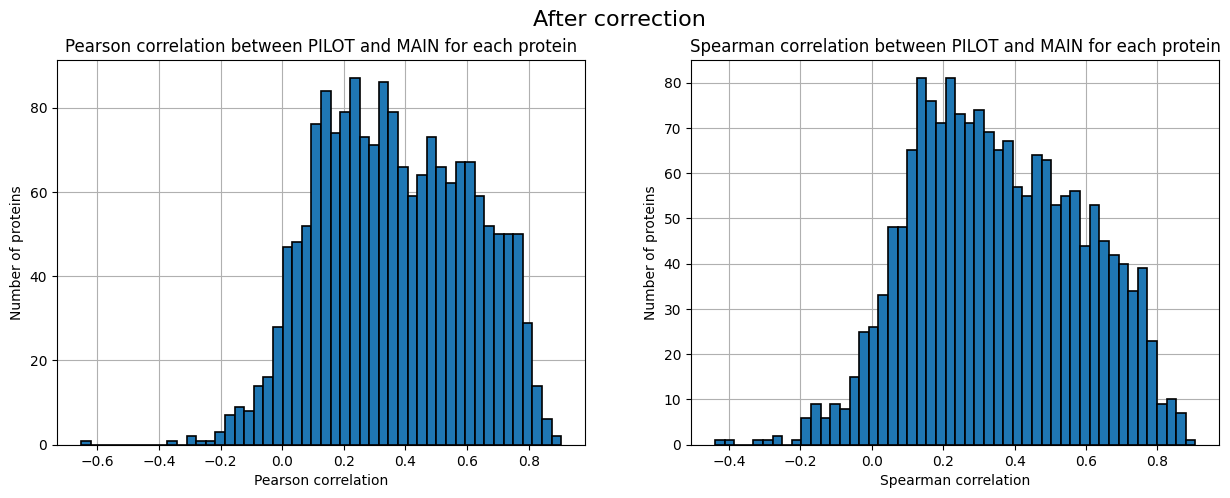

In [19]:
# before batch correction
pearson_correlations = []
spearman_correlations = []

for i in range(combined_adata.n_vars):
    intensity_MAIN = combined_adata.layers["MAIN"][:,i][overlap_filter[:,i]]
    intensity_PILOT = combined_adata.layers["PILOT"][:,i][overlap_filter[:,i]]

    pearson_correlations.append(np.corrcoef(intensity_MAIN, intensity_PILOT)[0, 1])
    spearman_correlations.append(spearmanr(intensity_MAIN, intensity_PILOT)[0])

fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
fig.suptitle("Before correction", fontsize=16)

ax = axes[0]
ax.hist(pearson_correlations, bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Pearson correlation between PILOT and MAIN for each protein")
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(spearman_correlations, bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Spearman correlation between PILOT and MAIN for each protein")
ax.set_xlabel("Spearman correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

# after batch correction
pearson_correlations = []
spearman_correlations = []

for i in range(combined_adata.n_vars):
    intensity_MAIN = combined_adata.layers["MAIN_corrected"][:,i][overlap_filter[:,i]]
    intensity_PILOT = combined_adata.layers["PILOT_corrected"][:,i][overlap_filter[:,i]]

    pearson_correlations.append(np.corrcoef(intensity_MAIN, intensity_PILOT)[0, 1])
    spearman_correlations.append(spearmanr(intensity_MAIN, intensity_PILOT)[0])

fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
fig.suptitle("After correction", fontsize=16)

ax = axes[0]
ax.hist(pearson_correlations, bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Pearson correlation between PILOT and MAIN for each protein")
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(spearman_correlations, bins=50, edgecolor="black", linewidth=1.2)
ax.set_title("Spearman correlation between PILOT and MAIN for each protein")
ax.set_xlabel("Spearman correlation")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

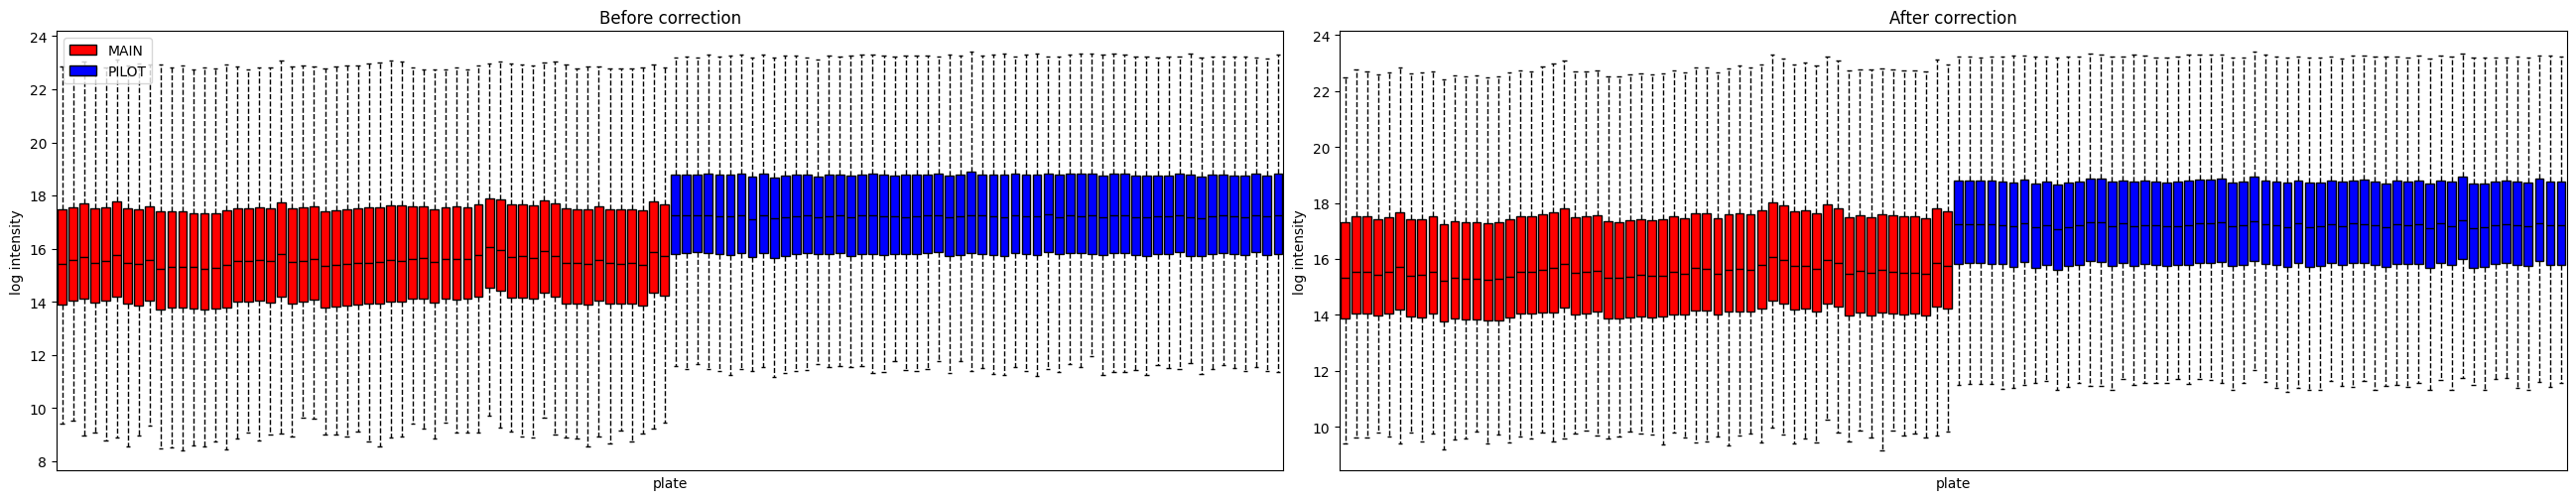

In [20]:
offset = 0

fig, axes = plt.subplots(figsize=(26, 5), ncols=2)
fig.tight_layout(pad=1)

# before
ax = axes[0]
ax.set_xlabel("plate")
ax.set_ylabel("log intensity")
ax.set_title("Before correction")

plates = combined_adata.obs["Plate"].unique()

ax.axes.set_xlim(-0.5 - offset, -0.5 + 2*len(plates) + offset)

for i, plate in enumerate(plates):
    adata_plate = combined_adata[combined_adata.obs["Plate"] == plate]
    intensities = adata_plate.layers["MAIN"][~np.isnan(adata_plate.layers["MAIN"])]

    ax.boxplot(intensities, positions=[i], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red"), medianprops=dict(color="black"),
               whiskerprops=dict(linestyle='--', color="black"), capprops=dict(linestyle='--', color="black"))

position_offset = len(plates)
for i, plate in enumerate(plates):
    adata_plate = combined_adata[combined_adata.obs["Plate"] == plate]
    intensities = adata_plate.layers["PILOT"][~np.isnan(adata_plate.layers["PILOT"])]

    ax.boxplot(intensities, positions=[position_offset + i], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="blue"), medianprops=dict(color="black"),
               whiskerprops=dict(linestyle='--', color="black"), capprops=dict(linestyle='--', color="black"))

# after
ax = axes[1]
ax.set_title("After correction")
ax.set_xlabel("plate")
ax.set_ylabel("log intensity")

plates = combined_adata.obs["Plate"].unique()

ax.axes.set_xlim(-0.5 - offset, -0.5 + 2*len(plates) + offset)

for i, plate in enumerate(plates):
    adata_plate = combined_adata[combined_adata.obs["Plate"] == plate]
    intensities = adata_plate.layers["MAIN_corrected"][~np.isnan(adata_plate.layers["MAIN_corrected"])]

    ax.boxplot(intensities, positions=[i], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="red"), medianprops=dict(color="black"),
               whiskerprops=dict(linestyle='--', color="black"), capprops=dict(linestyle='--', color="black"))

position_offset = len(plates)
for i, plate in enumerate(plates):
    adata_plate = combined_adata[combined_adata.obs["Plate"] == plate]
    intensities = adata_plate.layers["PILOT_corrected"][~np.isnan(adata_plate.layers["PILOT_corrected"])]

    # used dashed lines
    ax.boxplot(intensities, positions=[position_offset + i], widths=.8, showfliers=False, patch_artist=True, boxprops=dict(facecolor="blue"), medianprops=dict(color="black"),
               whiskerprops=dict(linestyle='--', color="black"), capprops=dict(linestyle='--', color="black"))


# legend
from matplotlib.patches import Patch

for ax in axes:
    ax.xaxis.set_ticklabels([])
    ax.set_xticks([])

legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='MAIN'),
    Patch(facecolor='blue', edgecolor='black', label='PILOT'),
]

axes[0].legend(handles=legend_elements, loc="upper left")

